# Gradient descent and backpropagation

- Part 2.1: With the same neural network from last week, understand how stochastic gradient descent is implemented.
- Part 2.2: Do pen and paper calculations of backpropagation

In [ ]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

## Exercises

### Part 2.1: Understanding SGD

Let's reuse Michael Nielsen's neural network from last session. Some new question are inserted in the comments (they start with "Q: "). Michael uses [list comprehensions](https://www.w3schools.com/python/python_lists_comprehension.asp) a lot, so make sure to learn that syntax.

In [ ]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""

        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, lr, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        n = len(training_data)
        if test_data:
            n_test = len(test_data)

        for j in range(epochs):

            # Q1: What happens here? Explain the contents of `mini_batches`.
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]

            # Q2: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)

            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, lr):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``lr``
        is the learning rate."""

        # These two vectors correspond to -∇C(W) (and -∇C(b))
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Q3: How does this code work to update `nabla_b` and `nabla_w`
        for x, y in mini_batch:
            nabla_b_i, nabla_w_i = self.backprop(x, y)
            nabla_b = [nb+nb_i for nb, nb_i in zip(nabla_b, nabla_b_i)]
            nabla_w = [nw+nw_i for nw, nw_i in zip(nabla_w, nabla_w_i)]

        # Q4: Now we have our gradient vectors, `nabla_b` and `nabla_w`. Explain how we use them
        # to update the weights and biases
        self.weights = [
            w - lr * nw / len(mini_batch)
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - lr * nb / len(mini_batch)
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # In backprop, we first do a feed forward step. We store all the
        # intermediate values that get computed. This is because, when we
        # compute the gradient on a weight, we ask how changing it a little
        # might influence the value that gets computed with it. Hence we need
        # to store these values.

        # Feedforward #
        # ----------- #

        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)


        # Backward pass #
        # ------------- #

        # Q5: What does the variable `delta` store here? Why is the last bias
        # gradient exactly `delta`?
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta

        # Q6: Seems like we are multiplying each of the outputs from the previous
        # layer, with the delta. Can you explain why we do this?
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())


        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.

        # Q7: What does this loop do?
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives dC_x/da
        for the output activations."""
        return output_activations - y


> **Ex. 2.1.1** Draw a overview illustrating which method depend on which method in the `Network` class. Below, give a short explanation as to what each method does.
>
> *Hint*: You can draw by hand take a picture and put it into the notebook, work your paint skills, make ascii art or whatever your inner creative finds easiest. Just as long as one can somehow read the relations in your answer.

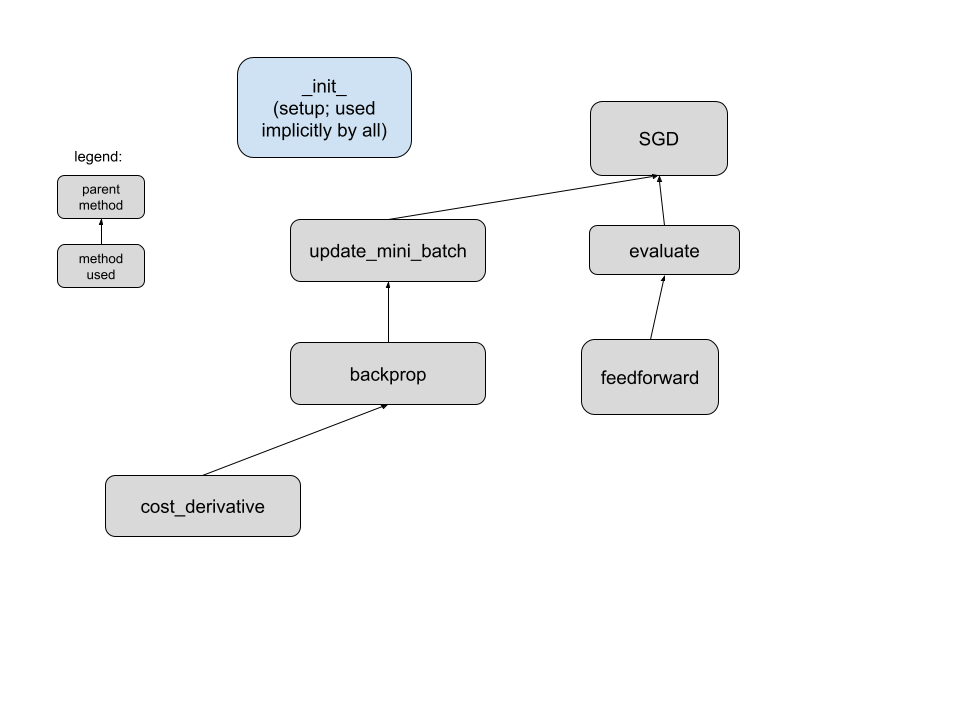

Explanation of methods:

**__init__**

Initializes the size and shape of the neural network (stores the number of neurons in each layer in a list) as well as the random weights and biases for the neurons.

**feedforward**

Computes the output of a neural network by processing the input *a* through each of its layers (applying the respective weights and biases, later feeding a as input into subsequent layer) until the final output is produced.

**SGD**

Represents a stochastic gradient descent algorithm. Adjusts the model's parameters (weights and biases) to minimize the cost function by randomly shuffling the training data, dividing it into smaller subsets (mini_batches) for efficiency, computing the gradient of the cost function for each of them, and finally updating the network's parameters iteratively over these batches using the computed gradients and a specified learning rate, repeating the process until the given number of epochs is completed. Prints the training process and evaluation results to the console depending on the *silent* flag parameter.

**update_mini_batch**

Accumulates the gradients of the cost function using backpropagation with respect to the weights and biases for each example within the mini-batch, and later updates the model's parameters by applying gradient descent using the accumulated gradients averaged over the mini-batch.

**evaluate**

Evaluates the performance of the neural network by computing the total number of correct predictions (compares the network's output with expected output) on the test dataset. Uses binary classification for networks of a single output neuron, and selects the class with the highest activation for multiple output neurons.

**backprop**

Computes the gradient of the cost function by first calculating the output of the neural network based on the current weights and biases, determining the activations for each neuron. Then, it calculates the cost derivative, which measures how far the network's output is from the true label for a given input (using the cost_derivative method). This error is then propagated backward through the network, computing the gradients for each layer’s weights and biases. Finally, these gradients are returned for updating the weights and biases accordingly.

**cost_derivative**

Helper method for backprop that calculates the gradient e.g. cost function partial derivative.


> **Ex. 2.1.2** Answer questions Q1-4 in the code. Write / code down the answer to each one of them in cells below.
>
> *Hint*: You need to closely follow the code. You can verify that your idea of what a variable contains is correct, if you print it. Simply create an instance of the network and you will be able to access the variables of that instance to see what they look like. Example:
>
>     net = Network([2, 3, 1])
>     net.biases  # this gets you the biases property of the network

Q1: What happens here? Explain the contents of `mini_batches`.

A1: The training data is shuffled and divided into mini-batches of size `mini_batch_size', where each mini-batch is a list of several (x,y) tuples - x is the input data and y is the expected output label - extracted from the training data starting at index k. These mini-batches are then the data used to update the weights and biases of the network - the randomness of their contents in each epoch prevents overfitting to any particular sequence of training data, and not using the entirety of the training data at once ensures more frequent updates of the model's parameters (thus, efficiency).

Q2: And what does this step do?

A2: It iterates over each mini-batch created earlier, and for each one, updates the network's weights and biases by applying gradient descent via backpropagation on the data in one that's currently being processed.
It then prints the progress of training after each epoch (depending on the *silent* flag), displaying either how many test cases the network got right if test data is provided, or prints that the epoch is complete if none is given.

Q3: How does this code work to update `nabla_b` and `nabla_w`

A3: For each trainig tuple (x, y) in the mini-batch, it calculates the gradient of the cost function with respect to the weights (nabla_w_i) and biases (nabla_b_i) - which represent how much each weight and bias should be adjusted to reduce the error for that *specific* training example - via the backprop method. It then accumulates these gradients across all training examples in the mini-batch by adding them to nabla_w and nabla_b which gives the average gradient for the entire mini-batch used to update the network's parameters.

Q4: Now we have our gradient vectors, `nabla_b` and `nabla_w`. Explain how we use them to update the weights and biases

A4: Once the average gradient for the mini-batch is computed, each element of the self_weights and self_biases list—representing the current weights and biases of the network—has the update formula applied. The learning rate times the average gradient (computed across all training examples in the mini-batch) is subtracted from each corresponding weight and bias value, after which the updated weights and biases are stored back into the list.

### Part 3.1: Backpropagation

**Your understanding** of neural networks should now be something along the lines of: (1) a datapoint propagates forward through the network, then (2) a cost (how bad the prediction is) is evaluated and its gradient wrt. each weight is computed, and finally (3) the weights are updated according to how much they influence the cost.

However, something important is missing from our understanding at this point. Remember, that *gradient descent* – the algorithm for minimizing the cost function, which we can think of as ball rolling downhill – needs to known which direction is downhill on the cost function. The gradient tells us this. **So how do we compute the cost function's gradient?** Enter: *backpropagation*. Backpropagation is an algorithm which computes the gradient of the cost function wrt. each weight in the network, from end to start, by iteratively applying *the chain rule*. It is called *back*-propagation because it computes gradients from front to back.

#### Pen and paper calculations

First, do some pen and paper calculations to hand-compute gradients in a real neural network.

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

> **Ex. 2.2.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?

The cost is approximately 0.073 and the residual is 0.73

> **Ex. 2.2.2**: Knowing about backpropagation, we actually have everything we need to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint*: When computing gradients with backprop, it can be helpful to think of the network as a [computational graph](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).
>
> *Hint*: Some of the gradients will become *very* small, known as the vanishing gradient problem. If they get smaller than 1e-4 you can just set them to zero.*
>
> *Note*: If you show me which equations you used and what your process is, I can give better feedback in case there are mistakes.

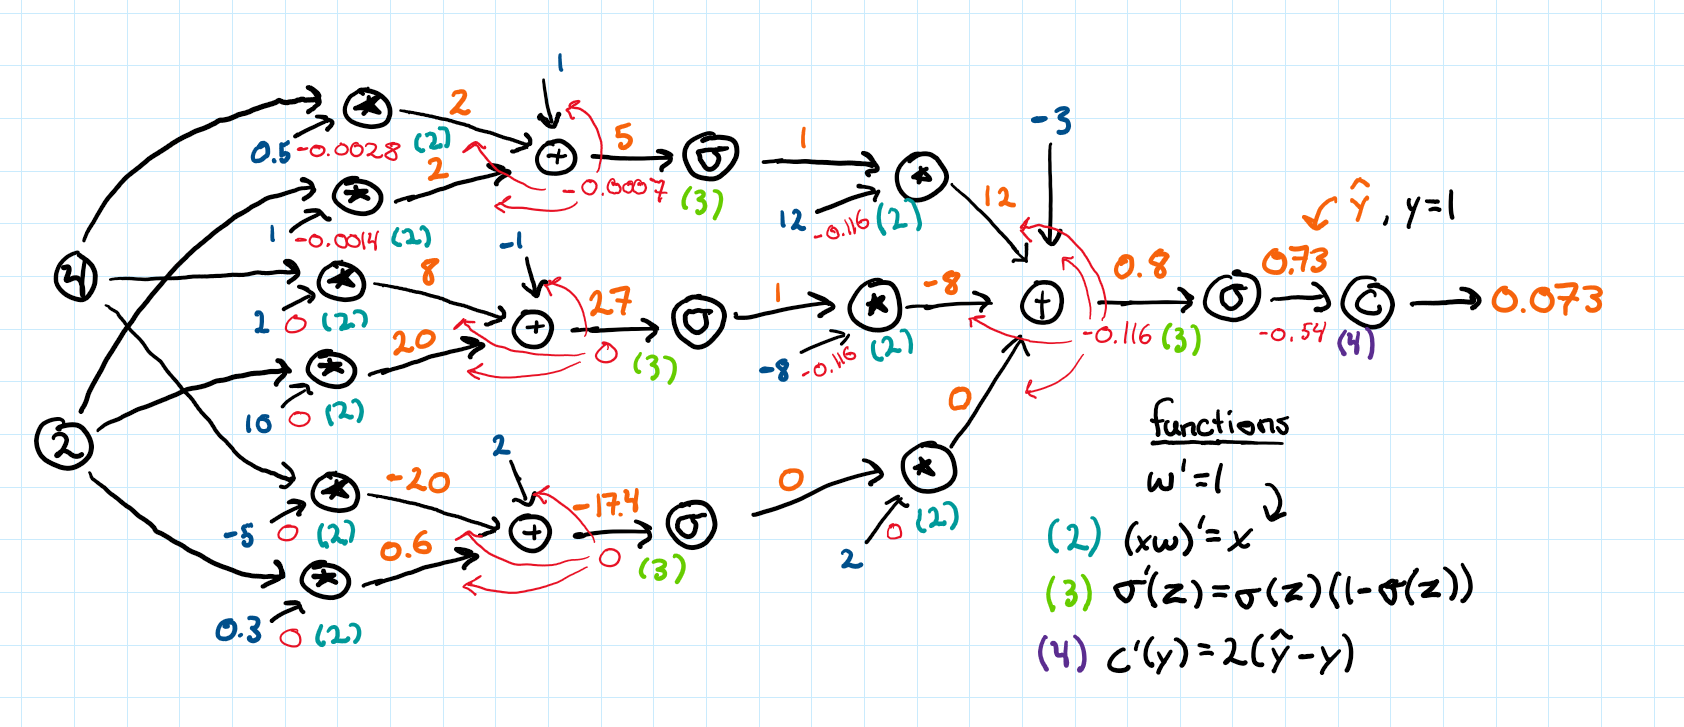

> **Ex. 2.2.3:** Provide answers to the code questions Q5-7.
>
>*Note:* `Q7` relies on having a solid grasp of the backpropagation equations (BP1-4) of Micheal Nielsens book. These cast what we learned today in vector notation, using matrix multiplication to compute the gradients of *vectors and matrices of weights*. You are not required to know these equations - the important thing is that you grasp the key ideas of backpropagation.


Q5: What does the variable `delta` store here? Why is the last bias gradient exactly `delta`?

A: In the backward pass, we start at the output layer and compute the error term, which is the gradient of the cost function (e.g., Mean Squared Error, MSE) with respect to the network's output. The delta stores the error term (the difference between the network's predicted output and the actual label)which captures how much the final layer's output deviates from the target value (y) multiplied by the derivative of the sigmoid activation function, which accounts for the sensitivity of the output to changes in the weighted input. The last bias gradient is set to delta because the bias directly shifts the neuron's output without involving any weights - since the bias only adds a constant shift to the activation, the required change to minimize the error is captured entirely by delta. In other words, the gradient of the cost function with respect to the bias is directly proportional to delta, meaning the error term is exactly the amount by which the bias needs to be adjusted to correct the output.

Q6: Seems like we are multiplying each of the outputs from the previous layer, with the delta. Can you explain why we do this?

A: The weight connects a neuron in the previous layer to a neuron in the current layer (in this case, the output layer). Therefore, the contribution of each weight to the error (delta) depends on both the current error term (which tells us how much the output neuron’s activation deviates from the target value) as well as the activations from the previous layer, which are the inputs that were multiplied by the weights to produce the output of the current layer. Multiplying the delta (error) by the activations from the previous layer gives us the gradient of the cost function with respect to each weight - i.e. shows how much the error changes as the weight changes (the sensitivity of the output with respect to the individual weights), taking into account both the aforementioned error in the current output and the input from the previous layer.

Q7: What does this loop do?

A: This loop now does what we just saw in Q5-6 iteratively, traveling backward through each of the layers, computing the error for the current layer by propagating the error from the next layer (previous layer in terms of the loop) which takes the delta of the previous iteration and multiplies it by the previous layers' activations. In other words, it effectively computes how each weight and bias in each layer should be adjusted to reduce the error, based on how changes in those weights and biases would affect the error.